@Author: Dev Bharti
Prior understanding of FastAI tabular model is necessary. Refer to their video 4 for more information (https://course.fast.ai/videos/?lesson=4)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *


Bad key "text.kerning_factor" on line 4 in
/home/dev/anaconda3/envs/deep_ai/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Create the dataframe from CSV and remove unnecessary columns

In [3]:
train_df = pd.read_csv('OUTPUT_WBI_exposer_cyclones_v10.csv')

In [4]:
train_df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
SID,1949163N07145,1950241N23140,1951224N12316,1951337N09150,1952180N05144
NAME,DELLA,JANE,CHARLIE,AMY,EMMA
ISO,JPN,JPN,JAM,PHL,PHL
YEAR,1949,1950,1951,1951,1952
BASIN,WP,WP,NAm,WP,WP
SUB BASIN,WP,WP,CS,WP,WP
NATURE,TS,ET,TS,TS,TS
ISO_TIME,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","['1951-08-17 21:00:00', '1951-08-18 12:00:00']","['1951-12-08 18:00:00', '1951-12-08 21:00:00',...","['1952-07-01 18:00:00', '1952-07-01 21:00:00',..."
COORDS,"[[35.67, 130.99], [38.35, 135.07], [38.82, 136...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]","[[17.34, -75.41], [18.3, -79.4]]","[[11.52, 127.35], [11.34, 127.09], [11.17, 126...","[[9.57, 127.79], [9.63, 127.19], [12.38, 119.4..."


In [ ]:
# tfm = FillMissing(['BASIN'], ['WIND_CALC_MEAN'])
# tfm(df_mod)
# df_mod.isna().sum()

In [6]:
df_mod = train_df.drop(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'DAY_HRS', 'NIGHT_HRS', 'in_wbi',
                 '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP', '96KN_ASSETS'], 
                 axis = 1)

In [7]:
# Adding month per Vamsi's code in SVM folder
df_mod['Month'] = df_mod.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

In [8]:
# Using Xavier's CPI logic...
df_mod["TOTAL_DAMAGE_(000$)_Adjusted"]= df_mod["TOTAL_DAMAGE_(000$)"] / df_mod["CPI"]
df_mod["TOTAL_DAMAGE_(000$)_Adjusted"]= df_mod["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
df_mod = df_mod.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
# df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

In [9]:
df_mod.isna().sum()

Unnamed: 0                                               0
BASIN                                                    0
SUB BASIN                                                0
NATURE                                                   0
ISO_TIME                                                 0
TOTAL_HRS                                                0
USA_SSHS                                                 0
WIND_CALC_MEAN                                           4
PRES_CALC_MEAN                                           0
STORM_SPD_MEAN                                           0
STORM_DR_MEAN                                            0
V_LAND_KN                                                0
TOTAL_DEATHS                                           134
Air transport, freight (million ton-km)                159
Arable land (hectares per person)                        1
Cereal yield (kg per hectare)                           10
Food production index (2004-2006 = 100)                 

# Prepare the categorical variables and continous variables to be passed to the Tabular Model

In [10]:
dep_var = 'TOTAL_AFFECTED'

cat_names = ['BASIN', 
             'SUB BASIN', 
             'NATURE', 
             'Income_level_Final', 
             'USA_SSHS',
             'Month']

cont_names = ['TOTAL_HRS',
#               'WIND_CALC_MEAN', 
              'PRES_CALC_MEAN', 
              'STORM_SPD_MEAN', 
              'STORM_DR_MEAN',
              'Mobile cellular subscriptions (per 100 people)',
              'Population density (people per sq. km of land area)',
              'V_LAND_KN',
              'Arable land (hectares per person)',
              'GDP per capita (constant 2010 US$)',
              'Air transport, freight (million ton-km)',
              'Cereal yield (kg per hectare)',
              'Food production index (2004-2006 = 100)',
              'GDP growth (annual %)',
              'Life expectancy at birth, total (years)',
              'Adjusted savings: education expenditure (% of GNI)',
              'Rural population (% of total population)']

#Features not used:
# WIND_CALC_MEAN
# 34KN_POP
# 34KN_ASSETS
# 64KN_POP
# 64KN_ASSETS
# 96KN_POP
# 96KN_ASSETS
# Net flows from UN agencies US$
# pop_max_34                                              
# pop_max_50                                              
# pop_max_64                                              
# pop_max_34_adj                                          
# pop_max_50_adj                                          
# pop_max_64_adj 
# Total Deaths

In [11]:
#FillMissing populates the NA values with Medians. Categorify converts categorical variables 
# into category data types and Normalise normalises the continous variables.
procs=[FillMissing, Categorify, Normalize]

In [12]:
#Helper function to generate a DataBunch from a dataframe, taking into account parameters
#log = True enables logs to be used for target variable (Total Affected)
data = (TabularList.from_df(df_mod, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .databunch())

In [13]:
data.show_batch(10)

BASIN,SUB BASIN,NATURE,Income_level_Final,USA_SSHS,Month,Mobile cellular subscriptions (per 100 people)_na,Arable land (hectares per person)_na,GDP per capita (constant 2010 US$)_na,"Air transport, freight (million ton-km)_na",Cereal yield (kg per hectare)_na,Food production index (2004-2006 = 100)_na,GDP growth (annual %)_na,"Life expectancy at birth, total (years)_na",Adjusted savings: education expenditure (% of GNI)_na,TOTAL_HRS,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),V_LAND_KN,Arable land (hectares per person),GDP per capita (constant 2010 US$),"Air transport, freight (million ton-km)",Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP growth (annual %),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),target
WP,WP,TS,Low_Middle,-1,9,False,False,False,True,False,False,False,False,False,1.0557,0.4490,-0.4625,0.6715,-0.9070,-0.0822,-1.6171,-0.3177,-0.6353,-0.4114,-0.0270,-1.2271,1.0965,0.1269,-0.5277,1.4069,9.305651
SI,SI,TS,Low_Middle,-1,1,False,False,False,True,False,False,False,False,False,1.0557,-0.1293,-0.8815,-0.2812,-0.9074,-0.2929,-0.0236,0.3798,-0.6168,-0.4114,-1.0617,-1.3051,0.5828,-3.7891,-0.2544,1.7848,11.225244
NAm,GM,TS,High,-1,9,False,False,False,False,False,False,False,False,False,1.0557,0.3941,-0.8408,-0.7322,-0.3847,-0.2739,-0.8631,1.2543,2.0779,2.7086,1.2678,-0.1097,-0.0170,0.8174,0.5493,-1.1506,1.7917595
NAm,GM,TS,High_Middle,-1,10,False,False,False,False,False,False,False,False,False,0.6497,0.3107,-0.2493,0.8559,-0.6115,-0.2536,0.4762,0.1190,-0.0644,-0.4288,-0.4343,-0.2330,0.1008,0.5026,0.4616,-0.9854,10.308952
SI,SI,TS,Low,3,1,False,False,False,False,False,False,False,False,False,-1.3802,-0.1691,0.2140,-0.4386,-0.8495,-0.2725,0.6671,-0.0697,-0.6398,-0.4651,-0.5782,0.2489,0.0141,-1.3420,-0.3255,1.0888,8.98532
WP,WP,TS,Low_Middle,0,6,False,False,False,False,False,False,False,False,False,1.0557,0.1621,1.4668,-1.9641,-0.6757,-0.1709,0.6417,-0.2703,-0.5462,0.0548,0.7562,-0.3548,0.9690,0.1361,-0.8064,0.7147,14.94949
WP,WP,TS,Low_Middle,0,11,False,False,False,False,False,False,False,False,False,-0.9742,-0.1561,-0.3056,-0.0454,-0.9074,-0.1603,1.3002,-0.1993,-0.5680,-0.4510,-1.1774,-1.5542,0.2694,-1.0538,-0.8010,0.7517,11.911265
WP,WP,TS,High,2,8,False,False,False,False,False,False,False,False,False,-1.7861,-0.3870,0.5967,0.8181,4.3250,6.5776,0.3235,-0.5224,1.8164,1.0636,-0.8783,-1.2183,-0.1785,1.9555,-0.2336,-2.1276,5.049856
WP,WP,TS,Low_Middle,1,11,False,False,False,False,False,False,False,False,False,0.6497,-0.3315,0.1806,0.7429,-0.9074,-0.1718,1.3638,-0.1918,-0.5787,-0.4587,-1.3311,-1.8298,-0.2529,-1.0648,-0.5793,0.8066,10.091542
NAm,GM,TS,High_Middle,0,9,False,False,False,False,False,False,False,False,False,1.0557,0.3727,-0.9610,0.2081,0.9596,-0.2436,-1.0095,0.0223,-0.0355,-0.3835,-0.0690,0.6671,-0.8161,0.5855,0.7286,-1.1651,10.819778


# Build the model

In [14]:
#Provides an upperbound for target variable
max_log_y = np.log(np.max(df_mod[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

# max_log_y = np.log(1.2) + np.max(df_mod[dep_var])
# y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [31]:
# creates a learner with embeddings
learn = tabular_learner(data, layers=[1000,500], loss_func = MSELossFlat(),
                        y_range=y_range, metrics=exp_rmspe, ps=[0.001,0.01], emb_drop=0.04) 

In [28]:
 learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 5)
    (1): Embedding(13, 7)
    (2): Embedding(7, 5)
    (3): Embedding(5, 4)
    (4): Embedding(12, 6)
    (5): Embedding(13, 7)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=77, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): D

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


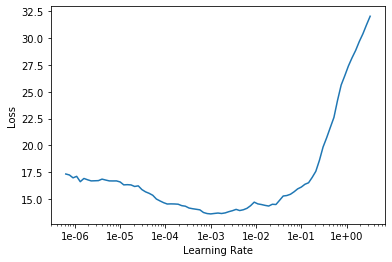

In [29]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit(10, 1e-04)

epoch,train_loss,valid_loss,exp_rmspe,time
0,12.908862,15.350591,62.670147,00:00
1,11.191874,15.916238,107.671356,00:00
2,10.267942,12.997273,141.552582,00:00
3,9.485785,12.031460,155.541061,00:00
4,8.850819,10.978799,184.845306,00:00
5,8.313293,10.649133,182.450714,00:00
6,7.832788,11.108624,133.226974,00:00
7,7.375824,11.569639,292.409729,00:00
8,7.070603,10.367273,484.280579,00:00
9,6.786057,11.392371,246.871613,00:00


In [ ]:
learn.save('1')

In [ ]:
# learn.recorder.plot_losses(skip_start=10000)